# Segmentation of Indian Traffic

In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [2]:
!ls

sample_data


In [3]:
!pip install tensorflow==2.2.0

!pip install keras==2.3.1 

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 3.0MB 33.8MB/s 
     |████████████████████████████████| 460kB 52.8MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 378kB 8.4MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

In [1]:
!curl --header "Host: doc-08-38-docs.googleusercontent.com" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header "Cookie: AUTH_6d0js5jug9va9kko1bs88tjhgrioghdl_nonce=5iisis1r90d1a" --header "Connection: keep-alive" "https://doc-08-38-docs.googleusercontent.com/docs/securesc/r4k5kcc708heeshnd7t9g12mf2avlq8a/meccv8ch15pc30mg1qus0j4chpgccvkm/1605760725000/00484516897554883881/17892243238344096031/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0&nonce=5iisis1r90d1a&user=17892243238344096031&hash=lolsd83j61hq6p09fkkf8fr3h25vgrkr" -L -o 'data.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2231M    0 2231M    0     0  81.3M      0 --:--:--  0:00:27 --:--:-- 91.1M


In [4]:
!unzip data.zip
!ls

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/images/377/frame31126_leftImg8bit.jpg  
  inflating: data/images/377/frame31426_leftImg8bit.jpg  
  inflating: data/imag

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [5]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    
    files=os.listdir(root_dir)
    image_path = []
    mask_path = []
    for file in files:
      if "images" in file:
        img_id_list = os.listdir(os.path.join(root_dir,"images"))
      if "mask" in file:
        mask_id_list = os.listdir(os.path.join(root_dir,"mask"))
    for id in tqdm(img_id_list):
      if id in mask_id_list:
        image_list = os.listdir(os.path.join(root_dir,"images",str(id)))
        polygon_list = os.listdir(os.path.join(root_dir,"mask",str(id)))
        image_list.sort()
        polygon_list.sort()
        if len(image_list) == len(polygon_list):
          for i in range(len(image_list)):
            image_path.append(os.path.join(root_dir,"images",str(id),image_list[i]))
            mask_path.append(os.path.join(root_dir,"mask",str(id),polygon_list[i]))
    data_df = pd.DataFrame({'image':image_path,'json':mask_path})
    return data_df

In [6]:
root_dir = "data"
data_df = return_file_names_df(root_dir)
data_df.head()

100%|██████████| 143/143 [00:00<00:00, 5046.58it/s]


,image,json
0,data/images/202/frame0018_leftImg8bit.jpg,data/mask/202/frame0018_gtFine_polygons.json
1,data/images/202/frame0389_leftImg8bit.jpg,data/mask/202/frame0389_gtFine_polygons.json
2,data/images/375/frame0014_leftImg8bit.jpg,data/mask/375/frame0014_gtFine_polygons.json
3,data/images/375/frame0644_leftImg8bit.jpg,data/mask/375/frame0644_gtFine_polygons.json
4,data/images/375/frame1014_leftImg8bit.jpg,data/mask/375/frame1014_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [7]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [9]:
grader_1(data_df)

True

In [10]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [7]:
import re
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    obj = []
    for i in tqdm(data_df.json.values):
      with open(i, 'r') as f:
        dat = json.load(f)
        lst = re.findall(r"'label': '(.*?)'",str(dat))
        
      obj.extend(lst)
    unique_labels = set(obj)
    return unique_labels

In [8]:
unique_labels = return_unique_labels(data_df)

100%|██████████| 4008/4008 [00:41<00:00, 96.89it/s] 


In [11]:
print(len(unique_labels))
unique_labels

40


{'animal',
 'autorickshaw',
 'bicycle',
 'billboard',
 'bridge',
 'building',
 'bus',
 'car',
 'caravan',
 'curb',
 'drivable fallback',
 'ego vehicle',
 'fallback background',
 'fence',
 'ground',
 'guard rail',
 'motorcycle',
 'non-drivable fallback',
 'obs-str-bar-fallback',
 'out of roi',
 'parking',
 'person',
 'pole',
 'polegroup',
 'rail track',
 'rectification border',
 'rider',
 'road',
 'sidewalk',
 'sky',
 'traffic light',
 'traffic sign',
 'trailer',
 'train',
 'truck',
 'tunnel',
 'unlabeled',
 'vegetation',
 'vehicle fallback',
 'wall'}

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [9]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [12]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [10]:
import ast
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    with open(file,'r') as f:
      dat = json.load(f)
      label = re.findall(r"'label': '(.*?)'",str(dat))
      h = re.findall(r"'imgHeight': (.*?),",str(dat))[0]
      w = re.findall(r"'imgWidth': (.*?),",str(dat))[0]
      vertexlist = []
      p = re.findall(r"'label': (.*?)]]",str(dat))
      if len(label) != len(p):
        label.pop(-1)
      f_p = [x+"]]" for x in p]
      for i in range(len(f_p)):
        pp = re.findall(r"'polygon': (.*?)]]",str(f_p[i]))
        for j in pp:
          d = j.split("'polygon':")
          if len(d) > 1:
            for k in range(len(d)-1):
              label.pop(i+k)
          d = d[-1].strip()
          ss = d +"]]"
          res = ast.literal_eval(ss)
          tuples = [tuple(x) for x in res]
          vertexlist.append(tuples)
      
    return int(w), int(h), label, vertexlist

In [12]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

[(18.0, 6.0), (15.363961030678928, 10.242640687119284), (9.0, 12.0), (2.636038969321073, 10.242640687119284), (0.0, 6.000000000000002), (2.6360389693210706, 1.7573593128807152), (8.999999999999998, 0.0), (15.363961030678928, 1.757359312880714)]
(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0

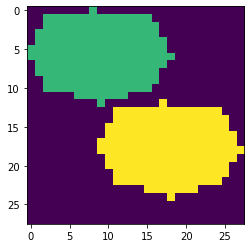

In [11]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
print(x1)
img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [12]:
os.mkdir('data/output')
os.mkdir('data/output/scene')
!ls data
!ls data/output/

images	mask  output
scene


In [ ]:
w, h, label, vertexlist = get_poly(data_df['json'].iloc[3306])
print(len(label),label)
print(len(vertexlist))

238 ['sky', 'road', 'drivable fallback', 'drivable fallback', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'billboard', 'billboard', 'billboard', 'billboard', 'obs-str-bar-fallback', 'billboard', 'billboard', 'building', 'obs-str-bar-fallback', 'pole', 'vegetation', 'vegetation', 'vegetation', 'building', 'building', 'polegroup', 'vehicle fallback', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'billboard', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'obs-str-bar-fallback', 'curb', 'vegetation', 'vegetation', 'vehicle fallback', 'billboard', 'billboard', 'vehicle fallback', 'obs-str-bar-fallback', 'obs-str-bar-fallback', 'obs-str-bar-fallback', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'obs-str-bar-fallback', 'car', 'obs-str-bar-fallback', 'vegetation', 'vehicle fallback', 'pole', 'po

In [ ]:
!ls data/output/scene/

In [13]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    msk = []
    
    for i in tqdm(range(data_df.shape[0])):
      w, h, label, vertexlist = get_poly(data_df['json'].iloc[i])
      img = Image.new("RGB", (w, h))
      img1 = ImageDraw.Draw(img)
      for j in range(len(label)):
        if len(vertexlist[j]) != 1:
          img1.polygon(vertexlist[j], fill = label_clr[label[j]])
      img=np.array(img)
      im = Image.fromarray(img[:,:,0])
      im_name = data_df['json'].iloc[i].split('/')[-1].replace('json','png')
      scene = re.findall(r"\d+",data_df['json'].iloc[i])
      if os.path.exists(os.path.join('data/output/',scene[0])) == False:
        os.mkdir(os.path.join('data/output/',scene[0]))
      msk_path = os.path.join('data/output/',scene[0],im_name)
      im.save(msk_path)
      msk.append(msk_path)
      
    data_df['mask'] = msk  
    return data_df

In [14]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [07:00<00:00,  9.53it/s]


,image,json,mask
0,data/images/202/frame0018_leftImg8bit.jpg,data/mask/202/frame0018_gtFine_polygons.json,data/output/202/frame0018_gtFine_polygons.png
1,data/images/202/frame0389_leftImg8bit.jpg,data/mask/202/frame0389_gtFine_polygons.json,data/output/202/frame0389_gtFine_polygons.png
2,data/images/375/frame0014_leftImg8bit.jpg,data/mask/375/frame0014_gtFine_polygons.json,data/output/375/frame0014_gtFine_polygons.png
3,data/images/375/frame0644_leftImg8bit.jpg,data/mask/375/frame0644_gtFine_polygons.json,data/output/375/frame0644_gtFine_polygons.png
4,data/images/375/frame1014_leftImg8bit.jpg,data/mask/375/frame1014_gtFine_polygons.json,data/output/375/frame1014_gtFine_polygons.png


True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


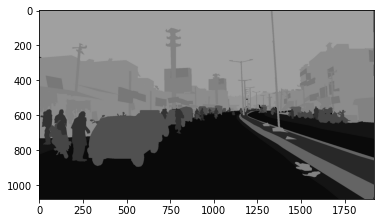

In [15]:
import urllib.request
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [16]:
import tensorflow as tf
#tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
#!pip install tensorflow==2.2.0

#!pip install keras==2.3.1 

In [17]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn

In [18]:
from tensorflow.keras.layers import Flatten

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df, test_size=0.15, random_state=42)

In [25]:
print(X_train.shape)
X_test.shape

(3406, 3)


(602, 3)

In [20]:
!pip install -U segmentation-models==0.2.1

     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 


In [21]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import Unet
#sm.set_framework('tf.keras')
#sm.framework()
tf.keras.backend.set_image_data_format('channels_last')
from segmentation_models.metrics import iou_score

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [22]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='sigmoid', input_shape=(256,256,3))


85524480/85521592 [==============================] - 3s 0us/step


In [23]:
model.summary()

Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________________

In [24]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
#aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
len(set(label_clr.values()))

21

In [25]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/10
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = label_clr.keys()
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, df,trainable=True):
        self.df_len = df.shape[0]
        # the paths of images
        self.images_fps   = df.image.values
        # the paths of segmentation images
        self.masks_fps    = df['mask'].values
        # giving labels for each class
        self.class_values = set(label_clr.values())
        self.trainable = trainable
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256,256),interpolation = cv2.INTER_AREA)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(mask, (256,256),interpolation = cv2.INTER_AREA)
        #image_mask = normalize_image(mask)
        
        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if self.trainable == True:
          a = np.random.uniform()
          if a<0.25:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
          elif a<0.5:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
          elif a<0.75:
            image = aug5.augment_image(image)
            image_mask = aug5.augment_image(image_mask)
          else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return self.df_len
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [26]:
optim = tf.keras.optimizers.Adam(0.00001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[iou_score])

In [27]:
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,ReduceLROnPlateau
# Dataset for train images
BATCHSIZE = 16
train_dataset = Dataset(X_train)
test_dataset  = Dataset(X_test,trainable=False)

train_dataloader = Dataloder(train_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCHSIZE, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCHSIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCHSIZE, 256, 256, 21)

log_dir="logs_m1"
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
#define callbacks for learning rate scheduling and best checkpoints saving
callbacks_1 = [
    ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)]

(16, 256, 256, 3)


In [28]:
%load_ext tensorboard

In [46]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20,\
                              validation_data=test_dataloader)

Epoch 1/20
212/212 [==============================] - 374s 2s/step - loss: 2.1763 - iou_score: 0.2647 - val_loss: 2.6962 - val_iou_score: 0.2984
Epoch 2/20
212/212 [==============================] - 355s 2s/step - loss: 1.5009 - iou_score: 0.3425 - val_loss: 7.8231 - val_iou_score: 0.2761
Epoch 3/20
212/212 [==============================] - 349s 2s/step - loss: 1.3547 - iou_score: 0.3593 - val_loss: 1.5776 - val_iou_score: 0.3642
Epoch 4/20
212/212 [==============================] - 352s 2s/step - loss: 1.2796 - iou_score: 0.3637 - val_loss: 1.6989 - val_iou_score: 0.3609
Epoch 5/20
212/212 [==============================] - 336s 2s/step - loss: 1.2574 - iou_score: 0.3699 - val_loss: 2.9783 - val_iou_score: 0.3134
Epoch 6/20
212/212 [==============================] - 317s 1s/step - loss: 1.2050 - iou_score: 0.3731 - val_loss: 1.7492 - val_iou_score: 0.3657
Epoch 7/20
212/212 [==============================] - 314s 1s/step - loss: 1.1591 - iou_score: 0.3795 - val_loss: 2.4288 - val_iou

In [59]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20,\
                              validation_data=test_dataloader)

Epoch 1/20
212/212 [==============================] - 341s 2s/step - loss: 0.6825 - iou_score: 0.4876 - val_loss: 1.5245 - val_iou_score: 0.4208
Epoch 2/20
212/212 [==============================] - 325s 2s/step - loss: 0.6847 - iou_score: 0.4759 - val_loss: 1.1083 - val_iou_score: 0.4570
Epoch 3/20
212/212 [==============================] - 325s 2s/step - loss: 0.7065 - iou_score: 0.4588 - val_loss: 1.1467 - val_iou_score: 0.4578
Epoch 4/20
212/212 [==============================] - 320s 2s/step - loss: 0.6851 - iou_score: 0.4815 - val_loss: 1.0914 - val_iou_score: 0.4521
Epoch 5/20
212/212 [==============================] - 321s 2s/step - loss: 0.6631 - iou_score: 0.4877 - val_loss: 1.1798 - val_iou_score: 0.4577
Epoch 6/20
212/212 [==============================] - 320s 2s/step - loss: 0.6688 - iou_score: 0.4758 - val_loss: 1.0811 - val_iou_score: 0.4594
Epoch 7/20
212/212 [==============================] - 325s 2s/step - loss: 0.6570 - iou_score: 0.4836 - val_loss: 1.2278 - val_iou

In [57]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=5,\
                              validation_data=test_dataloader)

Epoch 1/5
212/212 [==============================] - 334s 2s/step - loss: 0.5512 - iou_score: 0.4980 - val_loss: 0.8308 - val_iou_score: 0.4869
Epoch 2/5
212/212 [==============================] - 316s 1s/step - loss: 0.5346 - iou_score: 1.0652 - val_loss: 0.8295 - val_iou_score: 0.4870
Epoch 3/5
212/212 [==============================] - 317s 1s/step - loss: 0.5275 - iou_score: 0.5350 - val_loss: 0.8247 - val_iou_score: 0.4882
Epoch 4/5
212/212 [==============================] - 317s 1s/step - loss: 0.5285 - iou_score: 0.5261 - val_loss: 0.8270 - val_iou_score: 0.4888
Epoch 5/5
212/212 [==============================] - 319s 2s/step - loss: 0.5357 - iou_score: 0.5067 - val_loss: 0.8246 - val_iou_score: 0.4895


In [58]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=test_dataloader)

Epoch 1/10
212/212 [==============================] - 332s 2s/step - loss: 0.5283 - iou_score: 0.3632 - val_loss: 0.8239 - val_iou_score: 0.4899
Epoch 2/10
212/212 [==============================] - 318s 2s/step - loss: 0.5329 - iou_score: 0.4893 - val_loss: 0.8258 - val_iou_score: 0.4893
Epoch 3/10
212/212 [==============================] - 319s 2s/step - loss: 0.5347 - iou_score: 0.5517 - val_loss: 0.8220 - val_iou_score: 0.4901
Epoch 4/10
212/212 [==============================] - 317s 1s/step - loss: 0.5335 - iou_score: 0.5107 - val_loss: 0.8211 - val_iou_score: 0.4907
Epoch 5/10
212/212 [==============================] - 317s 1s/step - loss: 0.5187 - iou_score: 0.5767 - val_loss: 0.8230 - val_iou_score: 0.4913
Epoch 6/10
212/212 [==============================] - 318s 1s/step - loss: 0.5096 - iou_score: 0.5250 - val_loss: 0.8212 - val_iou_score: 0.4910
Epoch 7/10
212/212 [==============================] - 316s 1s/step - loss: 0.5178 - iou_score: 0.5288 - val_loss: 0.8208 - val_iou

In [59]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=test_dataloader)

Epoch 1/10
212/212 [==============================] - 330s 2s/step - loss: 0.5143 - iou_score: 0.5751 - val_loss: 0.8186 - val_iou_score: 0.4912
Epoch 2/10
212/212 [==============================] - 316s 1s/step - loss: 0.5146 - iou_score: 0.4959 - val_loss: 0.8206 - val_iou_score: 0.4914
Epoch 3/10
212/212 [==============================] - 319s 2s/step - loss: 0.5084 - iou_score: 0.7433 - val_loss: 0.8191 - val_iou_score: 0.4922
Epoch 4/10
212/212 [==============================] - 316s 1s/step - loss: 0.5066 - iou_score: 0.5213 - val_loss: 0.8215 - val_iou_score: 0.4912
Epoch 5/10
212/212 [==============================] - 318s 1s/step - loss: 0.5218 - iou_score: 0.5062 - val_loss: 0.8228 - val_iou_score: 0.4920
Epoch 6/10
212/212 [==============================] - 317s 1s/step - loss: 0.5143 - iou_score: 0.5216 - val_loss: 0.8197 - val_iou_score: 0.4913
Epoch 7/10
212/212 [==============================] - 318s 2s/step - loss: 0.5067 - iou_score: 0.4727 - val_loss: 0.8187 - val_iou

In [62]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=test_dataloader)

Epoch 1/10
212/212 [==============================] - 346s 2s/step - loss: 0.4984 - iou_score: 0.5245 - val_loss: 0.8194 - val_iou_score: 0.4917
Epoch 2/10
212/212 [==============================] - 317s 1s/step - loss: 0.5129 - iou_score: 0.5101 - val_loss: 0.8198 - val_iou_score: 0.4934
Epoch 3/10
212/212 [==============================] - 319s 2s/step - loss: 0.4997 - iou_score: -0.0947 - val_loss: 0.8205 - val_iou_score: 0.4914
Epoch 4/10
212/212 [==============================] - 320s 2s/step - loss: 0.5014 - iou_score: 0.5083 - val_loss: 0.8220 - val_iou_score: 0.4916
Epoch 5/10
212/212 [==============================] - 321s 2s/step - loss: 0.5134 - iou_score: 0.5300 - val_loss: 0.8165 - val_iou_score: 0.4929
Epoch 6/10
212/212 [==============================] - 319s 2s/step - loss: 0.4930 - iou_score: 0.5085 - val_loss: 0.8183 - val_iou_score: 0.4916
Epoch 7/10
212/212 [==============================] - 322s 2s/step - loss: 0.5043 - iou_score: 0.5372 - val_loss: 0.8183 - val_io

In [39]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=test_dataloader)

Epoch 1/10
212/212 [==============================] - 337s 2s/step - loss: 0.5302 - iou_score: 0.7275 - val_loss: 0.8419 - val_iou_score: 0.4922
Epoch 2/10
212/212 [==============================] - 320s 2s/step - loss: 0.5187 - iou_score: 0.4900 - val_loss: 0.8427 - val_iou_score: 0.4919
Epoch 3/10
212/212 [==============================] - 318s 1s/step - loss: 0.5353 - iou_score: 0.5085 - val_loss: 0.8408 - val_iou_score: 0.4916
Epoch 4/10
212/212 [==============================] - 321s 2s/step - loss: 0.5210 - iou_score: 0.5238 - val_loss: 0.8425 - val_iou_score: 0.4915
Epoch 5/10
212/212 [==============================] - 319s 2s/step - loss: 0.5419 - iou_score: 0.4988 - val_loss: 0.8438 - val_iou_score: 0.4922
Epoch 6/10
212/212 [==============================] - 322s 2s/step - loss: 0.5316 - iou_score: 0.5181 - val_loss: 0.8418 - val_iou_score: 0.4919
Epoch 7/10
212/212 [==============================] - 318s 1s/step - loss: 0.5299 - iou_score: 0.4315 - val_loss: 0.8431 - val_iou

In [31]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=50,\
                              validation_data=test_dataloader)

Epoch 1/50
212/212 [==============================] - 357s 2s/step - loss: 0.5452 - iou_score: 0.5361 - val_loss: 0.7494 - val_iou_score: 0.4968
Epoch 2/50
212/212 [==============================] - 325s 2s/step - loss: 0.5475 - iou_score: 0.4918 - val_loss: 0.7499 - val_iou_score: 0.4970
Epoch 3/50
212/212 [==============================] - 320s 2s/step - loss: 0.5278 - iou_score: 0.6221 - val_loss: 0.7509 - val_iou_score: 0.4967
Epoch 4/50
212/212 [==============================] - 316s 1s/step - loss: 0.5206 - iou_score: 0.5304 - val_loss: 0.7506 - val_iou_score: 0.4965
Epoch 5/50
212/212 [==============================] - 317s 1s/step - loss: 0.5402 - iou_score: 0.4195 - val_loss: 0.7509 - val_iou_score: 0.4965
Epoch 6/50
212/212 [==============================] - 317s 1s/step - loss: 0.5367 - iou_score: 0.4907 - val_loss: 0.7506 - val_iou_score: 0.4967
Epoch 7/50
212/212 [==============================] - 317s 1s/step - loss: 0.5359 - iou_score: 0.5159 - val_loss: 0.7502 - val_iou

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
!cp  '/content/drive/My Drive/UNet_weights_epoch_100_4_9.h5' UNet_weights_epoch_60_4_7.h5

In [30]:
model.load_weights("UNet_weights_epoch_60_4_7.h5")

In [ ]:
%tensorboard --logdir logs_m1

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>
* 1. Write the formualtion

class = tuple(range(1, len(y_pred.shape)-1)), 
numerator = 2. * np.sum(y_pred * y_true, class), 
denominator = np.sum(np.square(y_pred) + np.square(y_true), class), 
dice_loss = 1 - np.mean((numerator + epsilon) / (denominator + epsilon))

* 2. Range of the loss function

Loss Range from 0 to 1.WHere 1 denotes prefect or complete overlap and 0 denotes no overlap.

* 3. Interpretation of loss function

numerator/denominator, measures the overlap between actual pixel values with predicted pixel values for particular class. 
And fraction of this expected is large(means overlap is more).
And we take 1-numerator/denominator,here higher loss corresponds to low overlap and lower loss corresponds to more overlap.

* 4. Write your understanding of the loss function, how does it helps in segmentation

Each pixel of actual image is compared with predicted image pixel, if difference between pixel values is less then it overlaps more or overlaps less.
This is done with all pixels in image.
This loss helps in segmentation because classes are imbalanced in image.

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

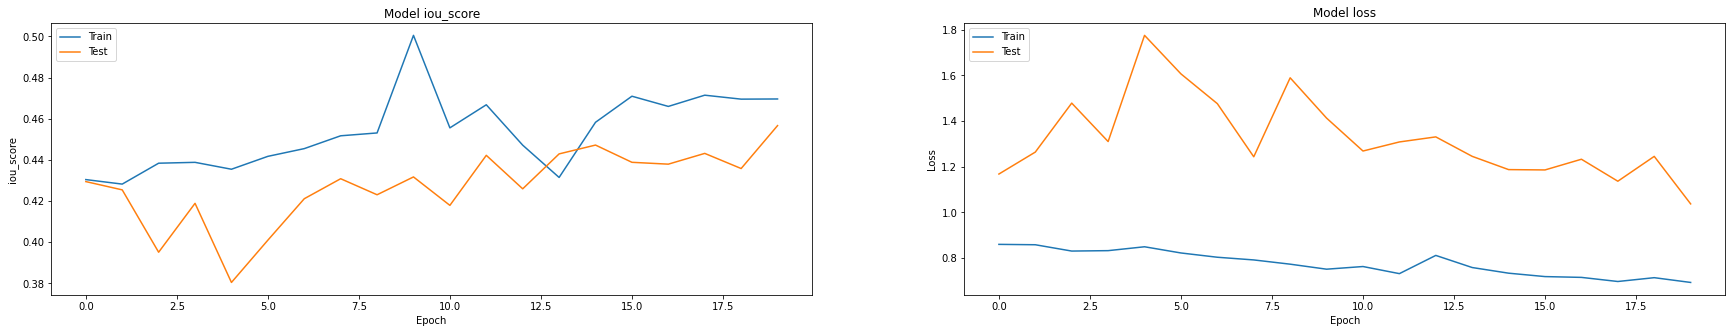

In [54]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

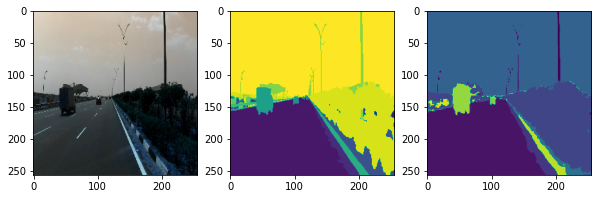

  5%|▌         | 1/20 [00:00<00:07,  2.68it/s]

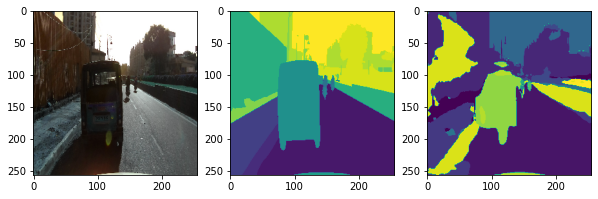

 10%|█         | 2/20 [00:00<00:06,  2.69it/s]

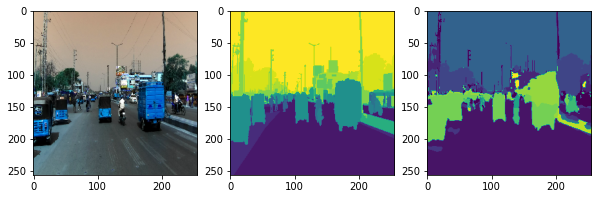

 15%|█▌        | 3/20 [00:01<00:06,  2.67it/s]

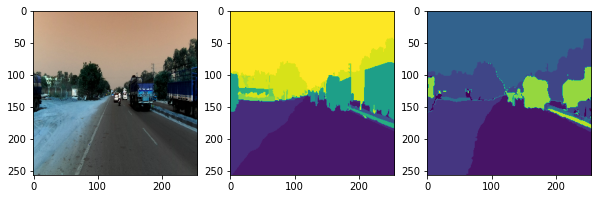

 20%|██        | 4/20 [00:01<00:05,  2.68it/s]

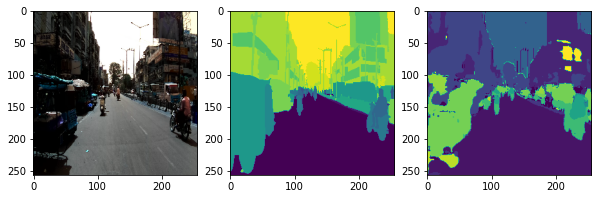

 25%|██▌       | 5/20 [00:01<00:05,  2.71it/s]

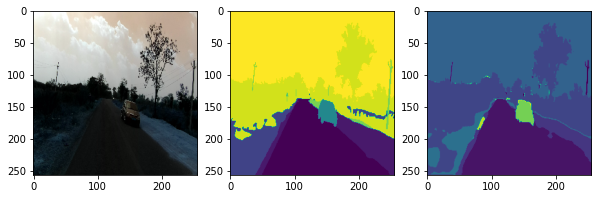

 30%|███       | 6/20 [00:02<00:05,  2.70it/s]

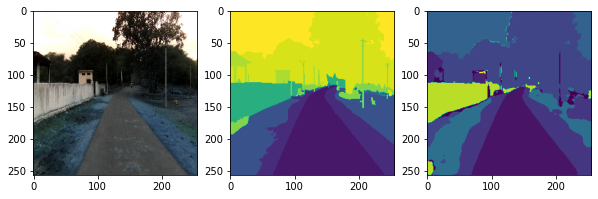

 35%|███▌      | 7/20 [00:02<00:04,  2.66it/s]

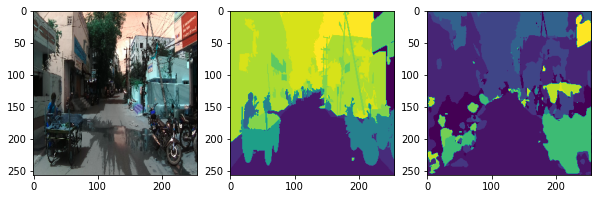

 40%|████      | 8/20 [00:02<00:04,  2.66it/s]

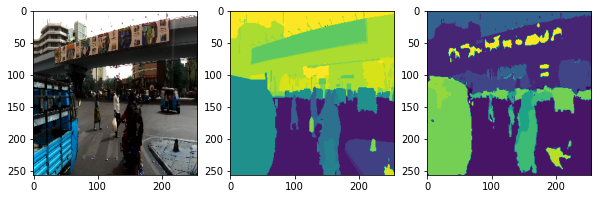

 45%|████▌     | 9/20 [00:03<00:04,  2.66it/s]

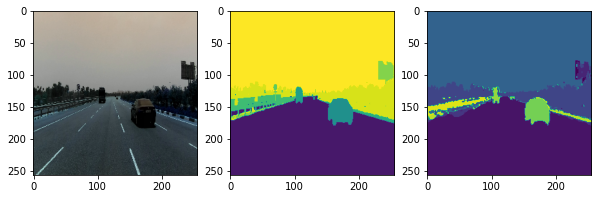

 50%|█████     | 10/20 [00:03<00:03,  2.71it/s]

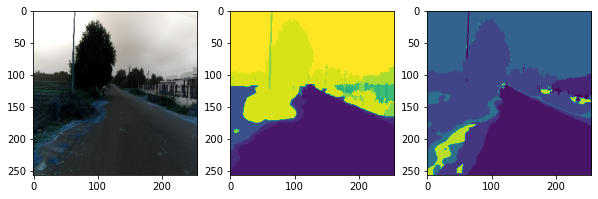

 55%|█████▌    | 11/20 [00:04<00:03,  2.60it/s]

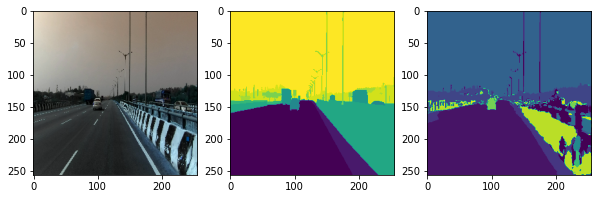

 60%|██████    | 12/20 [00:04<00:03,  2.66it/s]

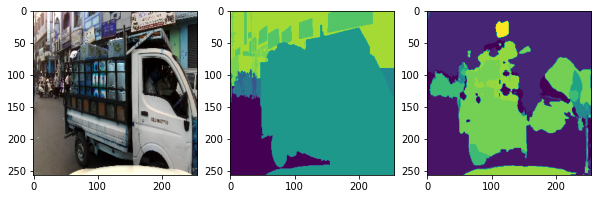

 65%|██████▌   | 13/20 [00:05<00:03,  2.09it/s]

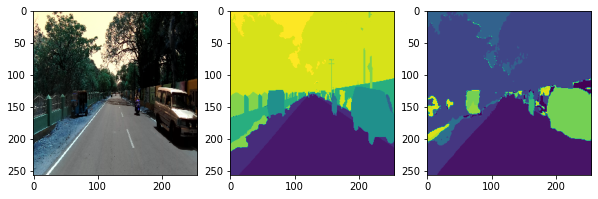

 70%|███████   | 14/20 [00:05<00:02,  2.23it/s]

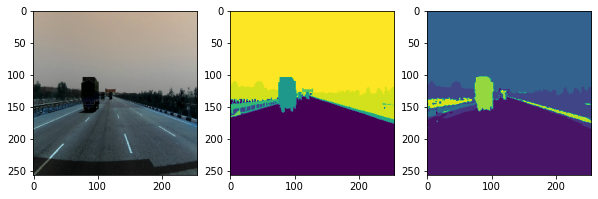

 75%|███████▌  | 15/20 [00:05<00:02,  2.36it/s]

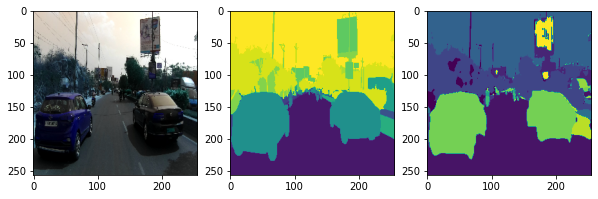

 80%|████████  | 16/20 [00:06<00:01,  2.41it/s]

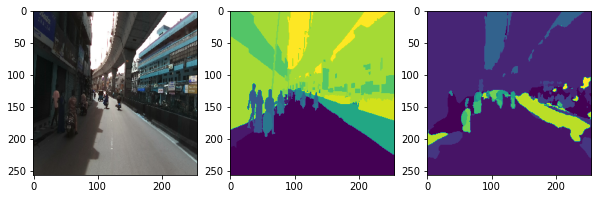

 85%|████████▌ | 17/20 [00:06<00:01,  2.48it/s]

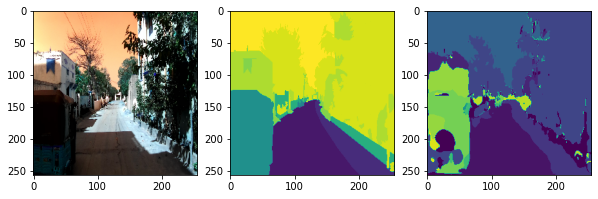

 90%|█████████ | 18/20 [00:07<00:00,  2.45it/s]

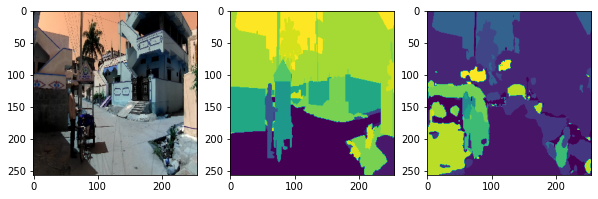

 95%|█████████▌| 19/20 [00:07<00:00,  2.52it/s]

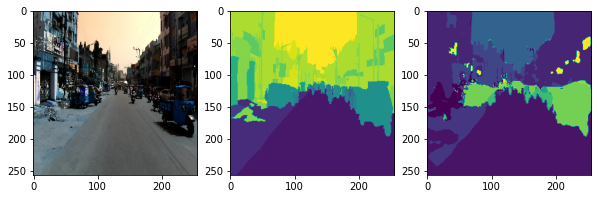

100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


In [55]:
for i in tqdm(range(20)):
    #original image
    x = np.random.randint(X_test.shape[0])
    image = cv2.imread(X_test['image'].iloc[x], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST)
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted, axis=-1)
    #original segmentation map
    image_mask = cv2.imread(X_test['mask'].iloc[x], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0])
    plt.show()

In [60]:
model.save_weights('UNet_weights_epoch_100_4_9.h5')

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
!cp UNet_weights_epoch_100_4_9.h5 '/content/drive/My Drive/'